In [ ]:
# AMATH 581 HW 1
# Jonathan McCormack 

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn, fftshift, ifftshift


In [2]:
# Load Submarine Data File
# Identify current directory and path to data file
print("Current working directory:", Path.cwd())
data_path = Path.cwd() / "subdata.npy" # "subdata.npy" is the name of the data file containing 3-D acoustic pressure from a submarine
print("Data path:", data_path)

d = np.load(data_path) # load file from data path -- (file is a matrix with columns containing flattened 3d matrix of size 64x64x64, each column is a different timepoint)

Current working directory: /home/jrmccormack20/Desktop/Code Repositories/AMATH 582/AMATH_582_Project_1
Data path: /home/jrmccormack20/Desktop/Code Repositories/AMATH 582/AMATH_582_Project_1/subdata.npy


In [3]:
# Define key variables
L = 10; # length of spatial domain (cube of side 2*L = 20)
N = 64; # number of grid points/Fourier modes in each direction
t = 49; # number of time points


x = np.linspace(-L, L, N+1, endpoint=False) # spatial grid in x direction
y = x # spatial grid in y,z direction
z = x
X, Y, Z = np.meshgrid(x, y, z) # generate 3D spatial meshgrid for plotting


k = (2*np.pi/(2*L))*np.linspace(-N/2, N/2-1, N) # frequency grid for one direction
KX, KY, KZ = np.meshgrid(k, k, k) # generate 3D frequency meshgrid

In [4]:
# Evaluate FFT
sum_fhat = np.zeros((N, N, N), dtype=complex)

for j in range(t):
    signal = np.reshape(d[:, j], (N, N, N))
    sum_fhat += fftshift(fftn(signal))

# Average presence of all frequencies across all timepoints
avg_fhat = np.abs(sum_fhat/49)

# Determine Dominant Frequency
indices = np.unravel_index(np.argmax(avg_fhat), avg_fhat.shape)
dfreq = (KX[indices], KY[indices], KZ[indices])
print("Dominant frequency (k): " + str(dfreq))

# Calculate Dominant freq in Hertz
sample_rate = 1/1800 # 1 sample per 30 minutes
dfreq_array = np.abs(np.array(dfreq))
dfreq_hertz = dfreq_array*sample_rate/N
dfreq_hertz = tuple(dfreq_hertz)
print("Dominant frequency (Hz): " + str(dfreq_hertz))

Dominant frequency (k): (np.float64(-5.340707511102648), np.float64(-2.199114857512855), np.float64(6.911503837897545))
Dominant frequency (Hz): (np.float64(4.636030825609938e-05), np.float64(1.9089538693687978e-05), np.float64(5.999569303730508e-05))


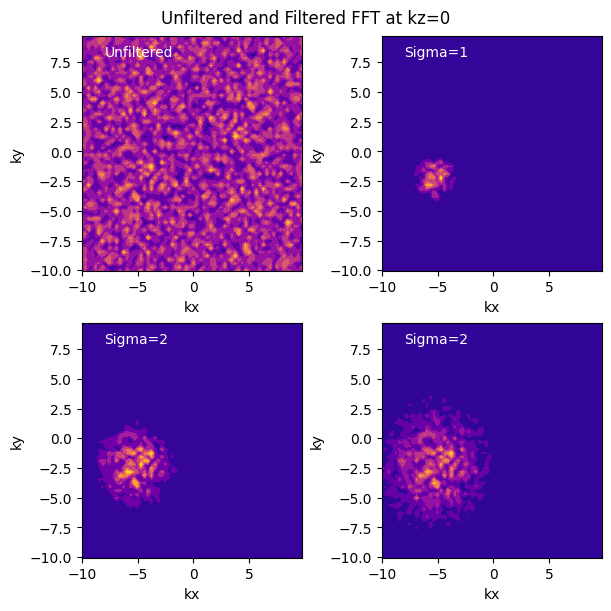

In [5]:
# Create the Gaussian Filter
def gauss_filter(x, y, z, avgx, avgy, avgz, sigma):
    return np.exp(-((x-avgx)**2 + (y-avgy)**2 + (z-avgz)**2) / (2*sigma**2))

# Plot of Unfiltered and Filtered FFT at kz=0
fig, axs = plt.subplots(2, 2, figsize=(6, 6),
                        layout="constrained")
fig.suptitle('Unfiltered and Filtered FFT at kz=0')

axs[0,0].contourf(k, k, avg_fhat[:,:,32], cmap = 'plasma')
axs[0,0].text(-8, 8, r'Unfiltered', fontsize = 10,c='white')
axs[0,0].set_xlabel('kx',fontsize=10); axs[0,0].set_ylabel('ky',fontsize=10)

sigma=1
filter = gauss_filter(KX, KY, KZ, KX[indices], KY[indices], KZ[indices], sigma)

axs[0,1].contourf(k, k, (filter*avg_fhat)[:,:,32], cmap = 'plasma')
axs[0,1].text(-8, 8, r'Sigma=1', fontsize = 10,c='white')
axs[0,1].set_xlabel('kx',fontsize=10); axs[0,1].set_ylabel('ky',fontsize=10)

sigma=2
filter = gauss_filter(KX, KY, KZ, KX[indices], KY[indices], KZ[indices], sigma)

axs[1,0].contourf(k, k, (filter*avg_fhat)[:,:,32], cmap = 'plasma')
axs[1,0].text(-8, 8, r'Sigma=2', fontsize = 10,c='white')
axs[1,0].set_xlabel('kx',fontsize=10); axs[1,0].set_ylabel('ky',fontsize=10)

sigma=3
filter = gauss_filter(KX, KY, KZ, KX[indices], KY[indices], KZ[indices], sigma)

axs[1,1].contourf(k, k, (filter*avg_fhat)[:,:,32], cmap = 'plasma')
axs[1,1].text(-8, 8, r'Sigma=2', fontsize = 10,c='white')
axs[1,1].set_xlabel('kx',fontsize=10); axs[1,1].set_ylabel('ky',fontsize=10)

fig.savefig('Figure1.png') 

Start at (2.9230769230769234, -7.846153846153846, -0.1538461538461533)
End at (-5.076923076923077, 6.0, 0.76923076923077)


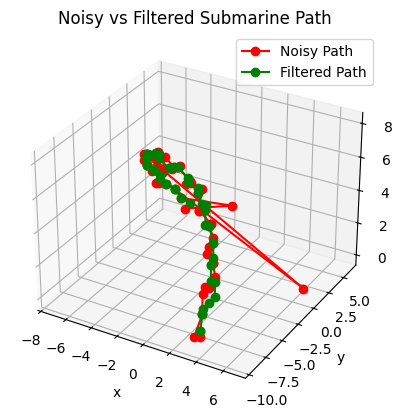

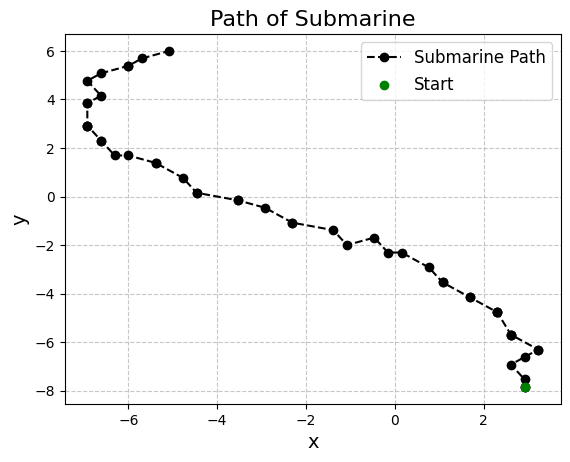

In [6]:
# Filtered Coordinates
xf = np.zeros(t)
yf = np.zeros(t)
zf = np.zeros(t)

# Noisy Coordinates
xn = np.zeros(t)
yn = np.zeros(t)
zn = np.zeros(t)

sigma=1
filter = gauss_filter(KX, KY, KZ, KX[indices], KY[indices], KZ[indices], sigma)

for j in range(t):
    signal = np.reshape(d[:, j], (N, N, N))
    signal_hat = fftshift(fftn(signal))
    clean_signal = signal_hat * filter  # Apply the filter
    filtered_spatial = np.real(ifftn(ifftshift(clean_signal)))
    unfiltered_spatial = np.real(ifftn(ifftshift(signal_hat))) # No filter applied
    index_filter = np.unravel_index(np.argmax(filtered_spatial), filtered_spatial.shape)
    index_noise = np.unravel_index(np.argmax(unfiltered_spatial), unfiltered_spatial.shape)

    xf[j] = X[index_filter]
    yf[j] = Y[index_filter]
    zf[j] = Z[index_filter]

    xn[j] = X[index_noise]
    yn[j] = Y[index_noise]
    zn[j] = Z[index_noise]


print(f'Start at ({xf[0]}, {yf[0]}, {zf[0]})')
print(f'End at ({xf[-1]}, {yf[-1]}, {zf[-1]})')
    
# 3D Plot of unfiltered and filtered Sub path
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(xn, yn, zn, 'ro', linestyle='-', label='Noisy Path')
ax.plot(xf, yf, zf, 'go', linestyle='-', label='Filtered Path')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Noisy vs Filtered Submarine Path')
ax.legend()
plt.show()
fig.savefig('Figure2.png') 

# 2D Plot of Submarine path
fig = plt.figure()
plt.plot(xf, yf, 'ko', linestyle='--', label="Submarine Path")
plt.scatter(xf[0], yf[0], color='green', label="Start", zorder = 5)  # Start point
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title('Path of Submarine', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()
fig.savefig('Figure3.png') 